## Imports

In [1]:
#@title IMPORTS+ nvidia-smi
from tensorflow.keras import preprocessing
import os
import json
from io import BytesIO
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.python.framework.ops import disable_eager_execution,enable_eager_execution
from tensorflow.image import rgb_to_grayscale

!nvidia-smi
print(tf.__version__)

Thu Mar 23 14:00:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    28W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Mount Drive
from google.colab import drive
DRIVE_DIR = '/content/drive/My Drive'
drive.mount('/content/drive')

Mounted at /content/drive


## Example of category encodigns

In [9]:

cats_dict = [
        {'id': 0, 'name': 'dresses',   'nn_output_id': 0, 'feed_cats': [331, 332, 333, 334, 335, 336, 330]},
        {'id': 1, 'name': 'tops',      'nn_output_id': 1, 'feed_cats': [241, 242, 243, 240, 291, 290, 341, 342, 343, 344, 340, 351, 352, 353, 350]},
        {'id': 2, 'name': 'skirts',    'nn_output_id': 2, 'feed_cats': [321, 322, 323, 324, 325, 326, 327, 328, 320]},
        {'id': 3, 'name': 'outerwear', 'nn_output_id': 3, 'feed_cats': [271, 272, 273, 274, 275, 276, 277, 278, 270, 281, 282, 283, 284, 280, 301, 302, 300]},
        {'id': 4, 'name': 'leggings',  'nn_output_id': 4, 'feed_cats': [311, 312, 313, 314, 315, 316, 310]},
        {'id': 5, 'name': 'footwear',  'nn_output_id': 0, 'feed_cats': [251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 250]},
        {'id': 6, 'name': 'bags',      'nn_output_id': 0, 'feed_cats': [371, 372, 373, 374, 375, 376, 370]},
]
clothing_cats = ['sukienka','top','spódnica','outwear','spodnie','buty','torba']

## Model Hyperparams

In [16]:
BATCH_SIZE = 194
IMG_SHAPE=(300,300)
INPUT_SHAPE=(300,300,3)
BACKBONE = 'EfficientNetB3'
ARCH_VERSION = 2
LOAD_TO_MEMORY=True

#priunt dataset size to decide if it should eb laoded into memory or dynamically loaded during training
dataset_memory_size = np.zeros((1),dtype='uint8').itemsize*INPUT_SHAPE[0]*INPUT_SHAPE[1]*INPUT_SHAPE[2]*TOTAL_WEIGHT_SUM
print("Predicted dataset size (GB): ",dataset_memory_size/float(1<<30))

Predicted dataset size (GB):  1.469263806939125


## Create image/imagepath array 

In [17]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
import PIL

if LOAD_TO_MEMORY is True:
  X = np.empty((N_TAGGED_IMAGES,)+INPUT_SHAPE,dtype='uint8')
  y = np.empty((N_TAGGED_IMAGES,N_CATEGORIES),dtype='int')
  for i,photo in enumerate(merged_json):
    y[i] = np.in1d(np.array(clothing_cats),photo['tags'])  
    X[i] = img_to_array(load_img(photo['files']['nn']['cache_path'],color_mode='rgb')) 
else:
  X = np.empty((N_TAGGED_IMAGES,),dtype=object)
  y = np.empty((N_TAGGED_IMAGES,N_CATEGORIES),dtype='int')
  for i,photo in enumerate(merged_json):
    y[i] = np.in1d(np.array(clothing_cats),photo['tags'])  
    X[i] = photo['files']['nn']['cache_path']
  y[len(merged_json):,:] = np.zeros((len(merged_untagged_json),N_CATEGORIES))



In [ ]:
#split images into training/test data
from sklearn.model_selection import train_test_split

TEST_FRAC = 0.15    
X_train, X_test, y_w_train, y_w_test, train_idcs,test_idcs = train_test_split(X,y_w,np.arange(len(X)),test_size=TEST_FRAC, random_state=0)
print("Train samples:", len(X_train),"Test samples:", len(X_test))


Train samples: 4966 Test samples: 877


## Define different architecture backbones, best results with EfficientNetB3

In [ ]:
#@title Get model fn
from tensorflow.keras import layers,Model
def get_model():    
    if(BACKBONE=='EfficientNetB3'):
        from tensorflow.keras.applications.efficientnet import EfficientNetB3,preprocess_input
        model_backbone = EfficientNetB3(weights='imagenet',include_top=False, input_shape=INPUT_SHAPE)
    elif(BACKBONE=='EfficientNetB4'):
        from tensorflow.keras.applications.efficientnet import EfficientNetB4,preprocess_input
        model_backbone = EfficientNetB4(weights='imagenet',include_top=False, input_shape=INPUT_SHAPE)
    elif(BACKBONE=='xception'):
        from tensorflow.keras.applications import Xception
        from tensorflow.keras.applications.xception import preprocess_input
        model_backbone = Xception(weights='imagenet',include_top=False, input_shape=INPUT_SHAPE)        
    model_backbone.trainable = False
    if ARCH_VERSION==0:
      x = layers.GlobalMaxPooling2D(name="max_pool")(model_backbone.outputs[0])
      x = layers.BatchNormalization()(x)
      x = layers.Flatten()(x)
      x = layers.Dropout(0.3)(x)
      x = layers.Dense(1024,activation='relu')(x)
      x = layers.Dropout(0.3)(x)
      output = layers.Dense(N_CATEGORIES,activation='sigmoid')(x)
    elif ARCH_VERSION==1:
      x = layers.GlobalMaxPooling2D(name="max_pool")(model_backbone.outputs[0])
      x = layers.BatchNormalization()(x)
      x = layers.Flatten()(x)
      x = layers.Dropout(0.3)(x)
      x = layers.Dense(1024,activation='relu')(x)
      x = layers.Dropout(0.3)(x)
      x = layers.Dense(1024,activation='relu')(x)
      x = layers.Dropout(0.3)(x)
      output = layers.Dense(N_CATEGORIES,activation='sigmoid')(x)
    elif ARCH_VERSION==2:
      x = layers.GlobalMaxPooling2D(name="max_pool")(model_backbone.outputs[0])
      x = layers.BatchNormalization()(x)
      x = layers.Flatten()(x)
      x = layers.Dropout(0.3)(x)
      x = layers.Dense(1024,activation='relu')(x)
      x = layers.Dropout(0.3)(x)
      output = layers.Dense(N_CATEGORIES,activation='linear')(x)
    else:
      raise ValueError()
    preprocessing_fn = preprocess_input
    model = Model(inputs = model_backbone.inputs, outputs = output)
    model.summary()
    return model, preprocessing_fn
model, preprocessing_fn = get_model()

## Create tf datasets

In [ ]:
from math import ceil

train_img_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.7,1.4),
    preprocessing_function=preprocessing_fn
    )
test_img_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocessing_fn)

val_steps = ceil(len(X_test)/BATCH_SIZE)
train_steps = ceil(len(X_train)/BATCH_SIZE)


if LOAD_TO_MEMORY is True:
  train_gen = train_img_gen.flow(x=X_train,y=y_w_train,shuffle=True,batch_size=BATCH_SIZE)
  val_gen = test_img_gen.flow(x=X_test,y=y_w_test,shuffle=False,batch_size=BATCH_SIZE)
else:
  import pandas as pd
  train_df = pd.DataFrame(data=X_train,  columns=["filenames"])
  for i in range(y_w_train.shape[1]):
    train_df['y_'+str(i)] = y_w_train[:,i]

  test_df = pd.DataFrame(data=X_test,  columns=["filenames"])
  for i in range(y_w_train.shape[1]):
    test_df['y_'+str(i)] = y_w_test[:,i]
  train_gen = train_img_gen.flow_from_dataframe(train_df,x_col='filenames',
                                              y_col=['y_'+str(i) for i in range(2*N_CATEGORIES)],
                                              shuffle=True,
                                              batch_size=BATCH_SIZE,
                                              class_mode='raw')
  val_gen = test_img_gen.flow_from_dataframe(test_df,x_col='filenames',
                                            y_col=['y_'+str(i) for i in range(2*N_CATEGORIES)],
                                            shuffle=False,
                                            batch_size=BATCH_SIZE,
                                            class_mode='raw')
  idx_for_tagged_testing = [i for i in range(len(X_test)) if "all_tags_02" in X_test[i]]
  test_gen = test_img_gen.flow_from_dataframe(test_df.loc[idx_for_tagged_testing],x_col='filenames',
                                            y_col=['y_'+str(i) for i in range(2*N_CATEGORIES)],
                                            shuffle=False,
                                            batch_size=BATCH_SIZE,
                                            class_mode='raw')

## Custom loss metrics, as parts of datasets are not fully tagged

In [ ]:
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.metrics import BinaryAccuracy,binary_accuracy
from tensorflow.keras.losses import BinaryCrossentropy, binary_crossentropy

def weighted_binary_accuracy(y_true, y_pred, w,threshold=0.5):
  y_pred = tf.convert_to_tensor(y_pred)
  threshold = tf.cast(threshold, y_pred.dtype)
  y_pred = tf.cast(y_pred > threshold, y_pred.dtype)
  nom = tf.math.reduce_sum(tf.cast(tf.equal(y_true, y_pred), y_true.dtype)*w, axis=-1)
  denom = tf.math.reduce_sum(w,axis=-1)
  return tf.math.divide_no_nan(nom,denom)

def get_acc_metric_per_output(n):
  def acc(y_true,y_pred):
    y_true,w = tf.split(y_true,num_or_size_splits=2,axis=1)
    return weighted_binary_accuracy(y_true[:,n],y_pred[:,n],w=w[:,n],threshold=0.0)
  acc.__name__ = 'acc_{}'.format(n)
  return acc
def bin_acc(y_true,y_pred):
    y_true,w = tf.split(y_true,num_or_size_splits=2,axis=1)
    return weighted_binary_accuracy(y_true[:,:],y_pred[:,:],w=w,threshold=0.0)

def loss(y_true,y_pred):
  y_true_,w = tf.split(y_true,num_or_size_splits=2,axis=1)
  l = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true_,logits=y_pred)  
  return tf.math.reduce_sum(l*w,axis=-1)/tf.math.reduce_sum(w,axis=-1)

metrics = [bin_acc]+[get_acc_metric_per_output(i) for i in range(N_CATEGORIES)]
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.316, patience=2)
earlyStop = EarlyStopping(patience=5,monitor='val_loss',restore_best_weights=True)
checkpoint =ModelCheckpoint(CHECKPOINT_DIR+'.ckpt',save_weights_only=True,verbose=1,save_best_only=True,monitor='val_loss')
callbacks = [checkpoint,reduce_lr,earlyStop]

model.compile(loss=loss,optimizer = 'adam',metrics=metrics)

## Pretraining with frozen weights

In [ ]:
model.fit(train_gen,
          steps_per_epoch = train_steps,
          epochs=200,
          validation_data=val_gen,
          validation_steps=val_steps,
          workers=8,
          callbacks=callbacks,
          use_multiprocessing=True)
#Epoch 00063: val_binary_accuracy did not improve from 0.91257

Epoch 1/200
26/26 [==============================] - ETA: 0s - loss: 0.4796 - bin_acc: 0.7980 - acc_0: 0.8139 - acc_1: 0.7178 - acc_2: 0.7626 - acc_3: 0.8179 - acc_4: 0.8267 - acc_5: 0.8470 - acc_6: 0.7620
Epoch 00001: val_loss improved from inf to 0.92200, saving model to /content/drive/My Drive/checkpoints/ObjReco_EfficientNetB3_v2_0121-143553.ckpt
26/26 [==============================] - 71s 2s/step - loss: 0.4796 - bin_acc: 0.7980 - acc_0: 0.8139 - acc_1: 0.7178 - acc_2: 0.7626 - acc_3: 0.8179 - acc_4: 0.8267 - acc_5: 0.8470 - acc_6: 0.7620 - val_loss: 0.9220 - val_bin_acc: 0.7772 - val_acc_0: 0.8681 - val_acc_1: 0.6693 - val_acc_2: 0.7765 - val_acc_3: 0.7969 - val_acc_4: 0.8569 - val_acc_5: 0.7645 - val_acc_6: 0.7161 - lr: 0.0010
Epoch 2/200
26/26 [==============================] - ETA: 0s - loss: 0.3551 - bin_acc: 0.8497 - acc_0: 0.8692 - acc_1: 0.7643 - acc_2: 0.8325 - acc_3: 0.8634 - acc_4: 0.8636 - acc_5: 0.9021 - acc_6: 0.8183
Epoch 00002: val_loss improved from 0.92200 to 0.

In [ ]:
model.save_weights(CHECKPOINT_DIR+".h5")

In [ ]:
model.load_weights(DRIVE_DIR+'/checkpoints/'+"ObjReco_xception_0_1209-154845.h5")

## Unfreeze backbone weights and fine-tune

In [ ]:
for layer_idx,layer in enumerate(model.layers):
  if not isinstance(layer, keras.layers.BatchNormalization) \
      and not(layer.name.startswith("block1")) \
      and not(layer.name.startswith("block2")) \
      and not(layer.name.startswith("block3")) \
      and layer_idx>15:
    layer.trainable = True
  else:
    layer.trainable = False

NEW_BATCH_SIZE = 96

In [ ]:
CHECKPOINT_DIR = DRIVE_DIR+'/checkpoints/ObjReco'+"_"+BACKBONE+"_"+str(ARCH_VERSION)+"_"+date_time+"Unfrz"
print(CHECKPOINT_DIR)

/content/drive/My Drive/checkpoints/ObjReco_EfficientNetB3_2_0121-143553Unfrz


In [ ]:
new_val_steps = ceil(len(X_test)/NEW_BATCH_SIZE)
new_train_steps = ceil(len(X_train)/NEW_BATCH_SIZE)
del train_gen
del val_gen

if LOAD_TO_MEMORY is True:
  train_gen = train_img_gen.flow(x=X_train,y=y_w_train,shuffle=True,batch_size=NEW_BATCH_SIZE)
  val_gen = test_img_gen.flow(x=X_test,y=y_w_test,shuffle=False,batch_size=NEW_BATCH_SIZE)
else:
  train_gen = train_img_gen.flow_from_dataframe(train_df,x_col='filenames',
                                              y_col=['y_'+str(i) for i in range(2*N_CATEGORIES)],
                                              shuffle=True,
                                              batch_size=NEW_BATCH_SIZE,
                                              class_mode='raw')
  val_gen = test_img_gen.flow_from_dataframe(test_df,x_col='filenames',
                                            y_col=['y_'+str(i) for i in range(2*N_CATEGORIES)],
                                            shuffle=False,
                                            batch_size=NEW_BATCH_SIZE,
                                            class_mode='raw')



In [ ]:
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.metrics import BinaryAccuracy,binary_accuracy
from tensorflow.keras.losses import BinaryCrossentropy

metrics = [bin_acc]+[get_acc_metric_per_output(i) for i in range(N_CATEGORIES)]
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.316, patience=2)
earlyStop = EarlyStopping(patience=5,monitor='val_loss',restore_best_weights=True)
checkpoint =ModelCheckpoint(CHECKPOINT_DIR+'.ckpt',save_weights_only=True,verbose=1,save_best_only=True,monitor='val_loss')
callbacks = [checkpoint,reduce_lr,earlyStop]

model.compile(loss=loss,optimizer = tf.keras.optimizers.Adam(learning_rate=2e-6) ,metrics=metrics)

In [ ]:
model.fit(train_gen,
          steps_per_epoch = new_train_steps,
          epochs=200,
          validation_data=val_gen,
          validation_steps=new_val_steps,
          workers=8,
          callbacks=callbacks,
          use_multiprocessing=True)


Epoch 1/200
52/52 [==============================] - ETA: 0s - loss: 0.1889 - bin_acc: 0.9200 - acc_0: 0.9353 - acc_1: 0.8616 - acc_2: 0.9138 - acc_3: 0.9273 - acc_4: 0.9269 - acc_5: 0.9557 - acc_6: 0.8944
Epoch 00001: val_loss improved from inf to 0.23323, saving model to /content/drive/My Drive/checkpoints/ObjReco_EfficientNetB3_2_0121-143553Unfrz.ckpt
52/52 [==============================] - 64s 838ms/step - loss: 0.1889 - bin_acc: 0.9200 - acc_0: 0.9353 - acc_1: 0.8616 - acc_2: 0.9138 - acc_3: 0.9273 - acc_4: 0.9269 - acc_5: 0.9557 - acc_6: 0.8944 - val_loss: 0.2332 - val_bin_acc: 0.9073 - val_acc_0: 0.9419 - val_acc_1: 0.8647 - val_acc_2: 0.8941 - val_acc_3: 0.9163 - val_acc_4: 0.8915 - val_acc_5: 0.9238 - val_acc_6: 0.8830 - lr: 2.0000e-06
Epoch 2/200
52/52 [==============================] - ETA: 0s - loss: 0.1858 - bin_acc: 0.9231 - acc_0: 0.9388 - acc_1: 0.8759 - acc_2: 0.9302 - acc_3: 0.9317 - acc_4: 0.9254 - acc_5: 0.9519 - acc_6: 0.8900
Epoch 00002: val_loss improved from 0.

In [ ]:
model.save_weights(CHECKPOINT_DIR+".h5")

In [ ]:
#del train_gen
#del val_gen
test_train_data_gen = test_img_gen.flow(x=X_train,y=y_w_train,shuffle=False,batch_size=BATCH_SIZE)
test_train_val_gen = test_img_gen.flow(x=X_test,y=y_w_test,shuffle=False,batch_size=BATCH_SIZE)

## Predict categories for train/test datasets and print out confusion matrix per category

In [ ]:
y_test_pred = model.predict(test_train_val_gen,steps=val_steps,batch_size=BATCH_SIZE)
y_train_pred = model.predict(test_train_data_gen,steps=train_steps,batch_size=BATCH_SIZE)

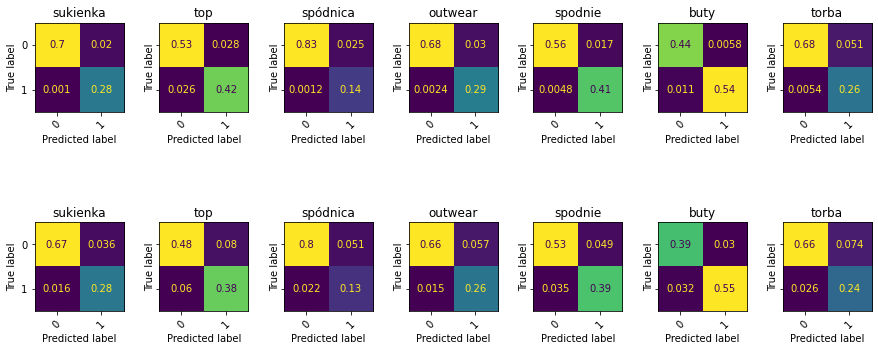

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, axes = plt.subplots(2,N_CATEGORIES,  sharey='row',figsize=(15,7))
axes = axes.ravel()
for c in range(N_CATEGORIES):
  #plt.subplot(2,N_CATEGORIES,c+1)
  cf = confusion_matrix(y_w_train[:,c],y_train_pred[:,c]>0.0,normalize='all')
  disp = ConfusionMatrixDisplay(cf)
  disp.plot(ax=axes[c], xticks_rotation=45)
  disp.ax_.set_title(clothing_cats[c])
  disp.im_.colorbar.remove()

for c in range(N_CATEGORIES):
  #plt.subplot(2,N_CATEGORIES,c+1)
  cf = confusion_matrix(y_w_test[:,c],y_test_pred[:,c]>0.0,normalize='all')
  disp = ConfusionMatrixDisplay(cf)
  disp.plot(ax=axes[N_CATEGORIES+c], xticks_rotation=45)
  disp.ax_.set_title(clothing_cats[c])
  disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()